In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
!pip install google-cloud-storage

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-jtnv1wn9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-jtnv1wn9
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=5cda7c8304a84ccaeb2d83f720bda9db9551e039b35997c79ea24cb29f6865ea
  Stored in directory: /tmp/pip-ephem-wheel-cache-uqqd1huu/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from scipy import ndimage
from datasets import Dataset
from PIL import Image
from google.cloud import storage
from io import BytesIO

In [5]:
client = storage.Client()  # Implicit environ set-up
training_bucket = client.get_bucket('training_images_solar')

#storing all the np.array images
original = []


for i in range(3000,3021):
    #import each picture from folder
    blob = training_bucket.blob(f'original/{i}.png')
    as_bytes = blob.download_as_bytes()
    im = Image.open(BytesIO(as_bytes))
    #resize w pillow!!
    im = im.resize((256, 256))
    # #append to list as an array
    original.append(np.asarray(im, dtype=np.uint8))

mask = []

for i in range(3000,3021):
    #import each picture from folder
    blob = training_bucket.blob(f'renamed_gray/{i}.png')
    as_bytes = blob.download_as_bytes()
    im = Image.open(BytesIO(as_bytes))
    #resize w pillow!!
    im = im.resize((256, 256))
    # #append to list as an array
    mask.append(np.asarray(im, dtype=np.uint8))

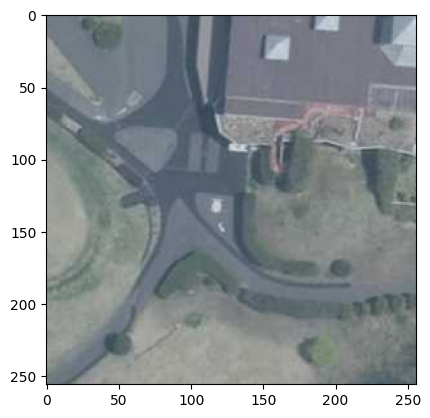

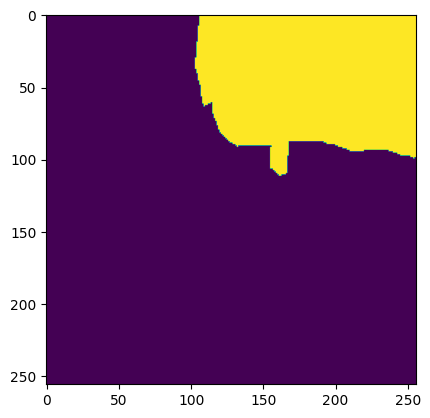

In [6]:
plt.imshow(original[8])
plt.show()
plt.imshow(mask[8])
plt.show()

In [7]:
original_np = np.array(original)
grays_np = np.array(mask)

In [8]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(mask) if mask.max() != 0]

# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = original_np[valid_indices]
filtered_masks = grays_np[valid_indices]

print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (11, 256, 256, 3)
Mask shape: (11, 256, 256)


In [9]:
#TRAIN / TEST SPLIT

train_percent = filtered_images.shape[0] * 0.8
train_percent = np.round(train_percent, 0).astype('int8')

training_split_img = filtered_images[:train_percent, :, :, :]
training_split_mask = filtered_masks[:train_percent, :, :]

test_split_img= filtered_images[train_percent:, :, :, :]
test_split_mask= filtered_masks[train_percent:, :, :]

In [10]:
print(training_split_img.shape)
print(test_split_img.shape)

(9, 256, 256, 3)
(2, 256, 256, 3)


In [11]:
from datasets import Dataset

dataset_dict = {
    "image": [Image.fromarray(img) for img in training_split_img],
    "label": [Image.fromarray(mask) for mask in training_split_mask],
}

# Create the dataset using the datasets.Dataset class
training_dataset = Dataset.from_dict(dataset_dict)

In [12]:
dataset_dict = {
    "image": [Image.fromarray(img) for img in test_split_img],
    "label": [Image.fromarray(mask) for mask in test_split_mask],
}

# Create the dataset using the datasets.Dataset class
test_dataset = Dataset.from_dict(dataset_dict)

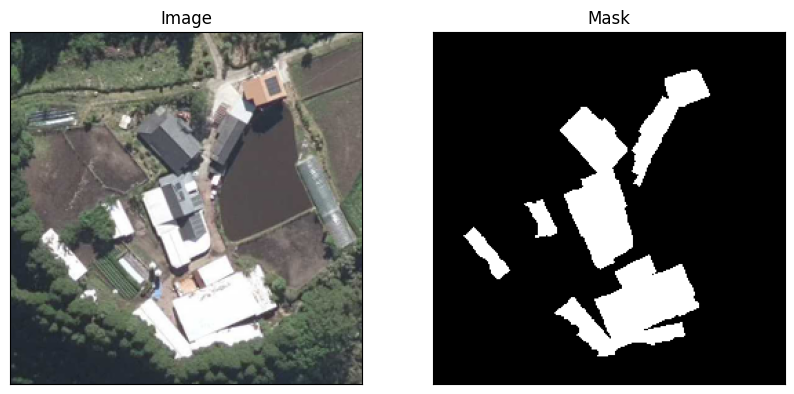

In [13]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = training_dataset[img_num]["image"]
example_mask = training_dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [14]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [15]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [16]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [17]:
train_dataset = SAMDataset(dataset=training_dataset, processor=processor)

In [18]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [19]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
# train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [20]:
# ### batch size
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True, drop_last=False)

In [21]:
testing_dataset = SAMDataset(dataset=test_dataset, processor=processor)
test_dataloader = DataLoader(testing_dataset, batch_size=1, shuffle=True, drop_last=False)

In [22]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([5, 3, 1024, 1024])
original_sizes torch.Size([5, 2])
reshaped_input_sizes torch.Size([5, 2])
input_boxes torch.Size([5, 1, 4])
ground_truth_mask torch.Size([5, 256, 256])


In [23]:
val_batch = next(iter(test_dataloader))

In [24]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [25]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [26]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [27]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

early_stopper = EarlyStopper(patience=3, min_delta=8)

#Training loop
num_epochs = 3

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    train_losses = []
    val_losses = []
    for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        with torch.no_grad():
          val_outputs = model(pixel_values=val_batch["pixel_values"].to(device),
                        input_boxes=val_batch["input_boxes"].to(device),
                        multimask_output=False)

          # compute loss
          val_predicted_masks = val_outputs.pred_masks.squeeze(1)
          val_ground_truth_masks = val_batch["ground_truth_mask"].float().to(device)
          val_loss = seg_loss(val_predicted_masks, val_ground_truth_masks.unsqueeze(1))
          val_losses.append(val_loss.item())

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        train_losses.append(loss.item())

        if early_stopper.early_stop(val_losses[-1]):
          break

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(train_losses)}')
    print(f'Mean val loss: {mean(val_losses)}')


100%|██████████| 2/2 [00:06<00:00,  3.28s/it]


EPOCH: 1
Mean loss: 0.5520555675029755
Mean val loss: 1.432895004749298


100%|██████████| 2/2 [00:04<00:00,  2.38s/it]


EPOCH: 2
Mean loss: 0.6206481903791428
Mean val loss: 1.3632075786590576


100%|██████████| 2/2 [00:04<00:00,  2.40s/it]

EPOCH: 3
Mean loss: 0.44166289269924164
Mean val loss: 1.3159446120262146


In [28]:
model.eval()

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

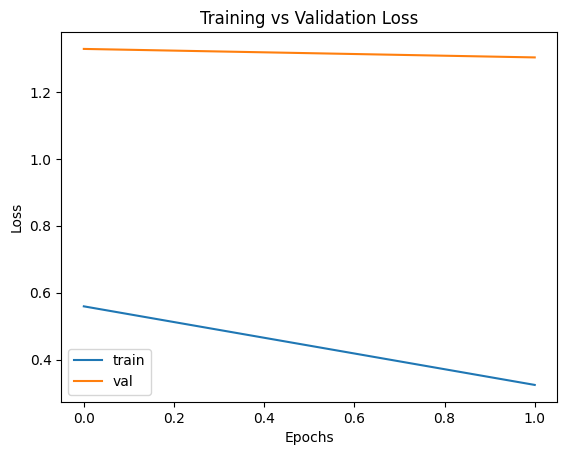

In [29]:
plt.plot(train_losses, label = "train")
plt.plot(val_losses, label = "val")
plt.legend()
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()